## Using Word Embedding

**Link to the Empirical Evaluation of CNN and RNN for sequence modeling: [here](https://arxiv.org/pdf/1803.01271.pdf)**



In this second part of the exercises, we will focus on [Word Embedding](https://en.wikipedia.org/wiki/Word_embedding), which is a powerful way to associate a vector with a word. "Word Embeddings" are low-dimensional floating point vectors (i.e. "dense" vectors, as opposed to sparse vectors). It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies.

There are two ways to obtain word embeddings:
- Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
- Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. These are called "pre-trained word embeddings".

### Learning Word Embedding with the `Embedding` layer

The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of such a noisy, unstructured embedding space.

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points far away from each other, while related words would be closer). Even beyond mere distance, we may want specific directions in the embedding space to be meaningful.

In real-world word embedding spaces, common examples of meaningful geometric transformations are "gender vectors" and "plural vector". For instance, by adding a "female vector" to the vector "king", one obtain the vector "queen". By adding a "plural vector", one obtain "kings". Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Is there some "ideal" word embedding space that would perfectly map human language and could be used for any natural language processing task? Possibly, but in any case, we have yet to compute anything of the sort. Also, there isn't such a thing as "human language", there are many different languages and they are not isomorphic, as a language is the reflection of a specific culture and a specific context. But more pragmatically, what makes a good word embedding space depends heavily on your task: the perfect word embedding space for an English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language legal document classification model, because the importance of certain semantic relationships varies from task to task.

It is thus reasonable to learn a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it even easier. It's just about learning the weights of a layer: the [Embedding layer](https://keras.io/api/layers/core_layers/embedding/).

<img src="images/word2vec.svg" width='700'/>

In [1]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens i.e. size of the vocabulary, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

The Embedding layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

The Embedding layer takes as input a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have shapes (32, 10) (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15). All sequences in a batch must have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape (samples, sequence_length, embedding_dimensionality). Such a 3D tensor can then be processed by a RNN layer or a 1D convolution layer (both will be introduced in the next sections).

When you instantiate an Embedding layer, its weights (its internal dictionary of token vectors) are initially random, just like with any other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single Dense layer on top for classification.

### Data Preprocessing

In [2]:
import numpy as np
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
# See RNN notebook for more explanations
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

### Building the Network

Let's build the following network:

- `Embedding` layer with `input_dim 10000`, `output_dim 8` and `input_length maxlen`. We specify the maximum input layer to the Embedding layer so we can later flatten the embedded inputs

- `Flatten` layer: to flatten the 3D tensor of embeddings into a 2D tensor of shape `(samples, maxlen * 8)`

- `Dense` layer : fully Connected layer, with `sigmoid` activation function as classifier

**Build the network as described above. Check Keras [documentation](https://keras.io/api/layers/core_layers/embedding/) to see what is exactly input_length.**

In [3]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)` == `(samples, 20 * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))

2022-01-14 00:33:21.960761: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Get a summary of the model.**

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


**Compile the model with `rmsprop` optimizer and `binary_crossentropy`.**

In [5]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

**Fit the model, as previously.**

In [6]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
610/625 [============================>.] - ETA: 0s - loss: 0.6648 - acc: 0.6419WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x144127710> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach

**What do you think of your results? Draw some conclusions.**

*Here are our training and validation results*: 

We get to a validation accuracy of ~75%, which is pretty good considering that we only look at the first 20 words in every review. But note that merely flattening the embedded sequences and training a single Dense layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and structure sentence. 

It would be much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole. 

Let's display the training and validation loss and accuracy:

**Fill in the #DO TOs to complete the plotting.**

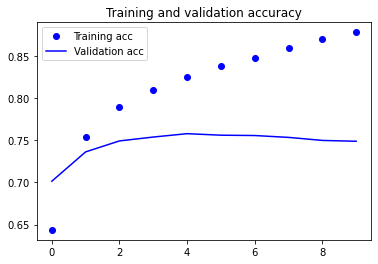

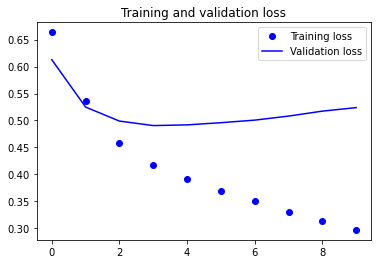

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Sequence Processing with Convnets

### Implementing a 1D convnet 

In Keras, you would use a 1D convnet via the [Conv1D layer](https://keras.io/api/layers/convolution_layers/convolution1d/), which has a very similar interface to Conv2D. It takes as input 3D tensors with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal axis, axis 1 in the input tensor.

**What do you think can be the advantage of using this kind of approach with respect to classical CNN?**
*Think a little bit about it and try to see which results you get from the implementation.*

1D convnets are structured in the same way as their 2D counter-parts that you have used in Chapter 5: they consist of a stack of Conv1D and MaxPooling1D layers, eventually ending in either a global pooling layer or a Flatten layer, turning the 3D outputs into 2D outputs, allowing to add one or more Dense layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.

As a reminder, this is the code for obtaining and preprocessing the data:

In [8]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


This is our example 1D convnet for the IMDB dataset. The network should look like this:
- `Embedding` layer, with input dimension equal to max_features, output dimension equal to 128 and input_length equal to max_len;
- `Conv1D` layer with 32 filters, kernel size 7 and ReLU activation function;
- `MaxPooling` layer with pooling size 5;
- `Conv1D` layer with 32 filters, kernel size 7 and ReLU activation function;
- `GlobalMaxPooling1D` layer;
- `Dense` layer, Output Fully Connected layer for classification;

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

**Get a summary of the model.**

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

*Note:* Here it is important to understand the output shape and number of parameters each layer has

**Compile the model with RMSprop with learning rate 1e-4, and `binary_crossentropy` loss function.**

In [11]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:368: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**Fit the model, as before.**

In [12]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
157/157 [==============================] - ETA: 0s - loss: 0.9230 - acc: 0.5085WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x14505fd40> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach

*Here are our training and validation results*: 

Validation accuracy is somewhat lower than that of the LSTM we used in previous notebook, but the runtime is faster, both on CPU and GPU (albeit the exact speedup will vary greatly depending on your exact configuration).

Let's display the training and validation loss and accuracy:

**Fill in the #DO TOs to complete the plotting.**

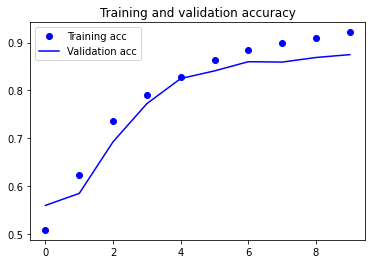

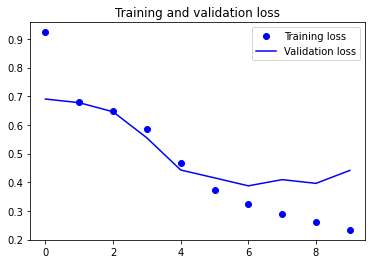

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This is a convincing demonstration that a 1D convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task.